In [13]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteFUTMHO/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteFUTMHO/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteFUTMHO/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [3]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [4]:
sample_string = "Dilawar is cool."

tokenized_string = tokenizer_en.encode(sample_string)
print(f"Tokenized string is {tokenized_string}")

original_string = tokenizer_en.decode(tokenized_string)
print(f"The original string: {original_string}")

assert original_string == sample_string

Tokenized string is [7899, 5135, 875, 13, 1671, 7877]
The original string: Dilawar is cool.


In [6]:
for ts in tokenized_string:
  print(f"{ts} ----> {tokenizer_en.decode([ts])}")

7899 ----> D
5135 ----> ila
875 ----> war 
13 ----> is 
1671 ----> cool
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [8]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]
  
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [9]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

In [10]:
MAX_LENGTH = 40

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [14]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [15]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [20]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [21]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding =  angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, tf.float32)

(1, 50, 512)


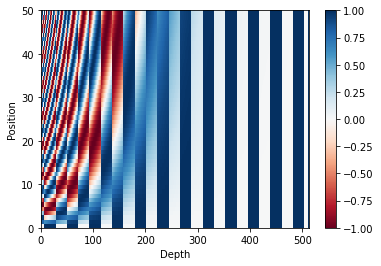

In [22]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim(0, 512)
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [23]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :]

In [24]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [25]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [26]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)

  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)
  
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [28]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print("Attention weights are:")
  print(temp_attn)
  print("Output is:")
  print(temp_out)

In [30]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [31]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [32]:
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [33]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [38]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  
    k = self.wk(k)  
    v = self.wv(v)  
    
    q = self.split_heads(q, batch_size)  
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)  
    
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  

    output = self.dense(concat_attention)  
        
    return output, attention_weights

In [39]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [40]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])

In [41]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [42]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
  
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [44]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [47]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
  
  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [48]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

In [49]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    
    self.dropout = tf.keras.layers.Dropout(rate)
  
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x

In [50]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)

(64, 62, 512)


In [51]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    
    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights[f"decoder_layer{i+1}_block1"] = block1
      attention_weights[f"decoder_layer{i+1}_block2"] = block2
    
    return x, attention_weights

In [52]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn["decoder_layer2_block2"].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [53]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)
    
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):
    
    enc_output = self.encoder(inp, training, enc_padding_mask)

    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)

    return final_output, attention_weights

In [54]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=2, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape

TensorShape([64, 36, 8000])

In [56]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [57]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [58]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

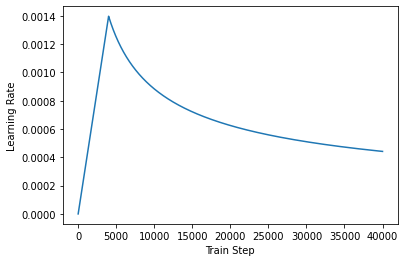

In [59]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [60]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none")

In [61]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [62]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name="train_accuracy")

In [63]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [64]:
def create_masks(inp, tar):
  enc_padding_mask = create_padding_mask(inp)

  dec_padding_mask = create_padding_mask(inp)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [65]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored!!")

In [66]:
EPOCHS = 20

In [67]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [69]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f"Epoch {epoch+1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}")
  
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f"Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}")
  
  print(f"Epoch {epoch+1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}")

  print(f"Time taken for 1 epoch: {time.time() - start} secs\n")

Epoch 1 Batch 0 Loss 9.0118 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9607 Accuracy 0.0029
Epoch 1 Batch 100 Loss 8.8640 Accuracy 0.0102
Epoch 1 Batch 150 Loss 8.7568 Accuracy 0.0133
Epoch 1 Batch 200 Loss 8.6271 Accuracy 0.0156
Epoch 1 Batch 250 Loss 8.4714 Accuracy 0.0197
Epoch 1 Batch 300 Loss 8.2955 Accuracy 0.0238
Epoch 1 Batch 350 Loss 8.1105 Accuracy 0.0282
Epoch 1 Batch 400 Loss 7.9296 Accuracy 0.0325
Epoch 1 Batch 450 Loss 7.7633 Accuracy 0.0358
Epoch 1 Batch 500 Loss 7.6176 Accuracy 0.0386
Epoch 1 Batch 550 Loss 7.4856 Accuracy 0.0418
Epoch 1 Batch 600 Loss 7.3604 Accuracy 0.0452
Epoch 1 Batch 650 Loss 7.2408 Accuracy 0.0486
Epoch 1 Batch 700 Loss 7.1270 Accuracy 0.0519
Epoch 1 Loss 7.1227 Accuracy 0.0520
Time taken for 1 epoch: 74.32840299606323 secs

Epoch 2 Batch 0 Loss 5.5209 Accuracy 0.0981
Epoch 2 Batch 50 Loss 5.4874 Accuracy 0.1020
Epoch 2 Batch 100 Loss 5.4399 Accuracy 0.1043
Epoch 2 Batch 150 Loss 5.3955 Accuracy 0.1068
Epoch 2 Batch 200 Loss 5.3506 Accuracy 0.1088
Ep

In [70]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]

  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
    
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    predictions = predictions[:, -1:, :]

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [71]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_pt.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    ax.matshow(attention[head][:-1, :], cmap="viridis")

    fontdict = {"fontsize": 10}

    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))

    ax.set_ylim(len(result)-1.5, -0.5)

    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'],
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                        if i < tokenizer_en.vocab_size],
                       fontdict=fontdict)
    
    ax.set_xlabel(f"Head {head+1}")

  plt.tight_layout()
  plt.show()

In [72]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode([i for i in result
                                            if i < tokenizer_en.vocab_size])
  
  print(f"Input: {sentence}")
  print(f"Predicted translation: {predicted_sentence}")

  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [73]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: so this is a problem that we have to solve it .
Real translation: this is a problem we have to solve .


In [74]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [75]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to be quickly sharing with you some magic stories that happened.
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did .


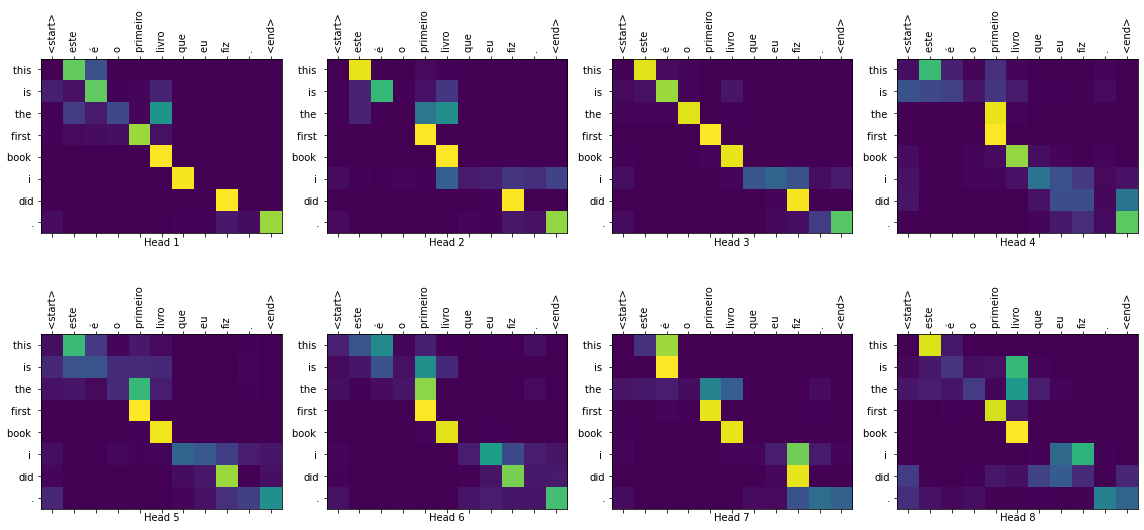

Real translation: this is the first book i've ever done.


In [76]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")